# 03 — Orthogonal Four-Basis Decomposition

Demonstrates the full projection workflow on a **real blocking event**:

1. Build the orthogonal basis {Φ₁, Φ₂, Φ₃, Φ₄} from the PV anomaly field
2. Project the PV tendency onto the basis → (β, αx, αy, γ)
3. Lifecycle time curves by looping over ∆h = −13 … +12

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pvtend import (compute_orthogonal_basis, project_field, R_EARTH)
from pvtend.plotting import plot_four_basis, plot_coefficient_curves, plot_field_2d
from pvtend.decomposition.projection import collect_term_fields, ADVECTION_TERMS
from pvtend.decomposition.basis import PRENORM_PHI1, PRENORM_PHI2, PRENORM_PHI3, PRENORM_PHI4

## 1  Load event data at onset (dh = 0)

In [2]:
DATA_ROOT = "/net/flood/data2/users/x_yan/tempest_extreme_4_basis/outputs_tmp"
STAGE = "onset"
TRACK_GLOB = "track_100_*"   # 1992-08-05 blocking event

d0 = dict(np.load(f"{DATA_ROOT}/blocking_tmp/{STAGE}/dh=+0/{TRACK_GLOB.replace('*','1992080507_dh+0')}.npz"))
X_rel = d0["X_rel"]
Y_rel = d0["Y_rel"]
x_rel = X_rel[0, :]    # 1D
y_rel = Y_rel[:, 0]

print(f"Patch shape : {X_rel.shape}")
print(f"PV anom min : {d0['pv_anom'].min():.3e} PVU")

Patch shape : (29, 49)
PV anom min : -4.065e-06 PVU


## 2  Build orthogonal basis from PV anomaly

In [3]:
basis = compute_orthogonal_basis(
    pv_anom=d0["pv_anom"],
    pv_dx=d0["pv_anom_dx"],
    pv_dy=d0["pv_anom_dy"],
    x_rel=x_rel,
    y_rel=y_rel,
    mask_negative=True,
    apply_smoothing=True,
    smoothing_deg=6.0,
    grid_spacing=1.5,
)
print("Basis norms :", {k: f"{v:.4e}" for k, v in basis.norms.items()})
print("Scale factors:", basis.scale_factors)

Basis norms : {'beta': '9.8555e+02', 'ax': '4.9253e+03', 'ay': '2.0093e+03', 'gamma': '8.3289e+03'}
Scale factors: {'beta': 1000000.0, 'ax': 1000000000000.0, 'ay': 1000000000000.0, 'gamma': 1e+18}


## 3  Visualise the four basis fields

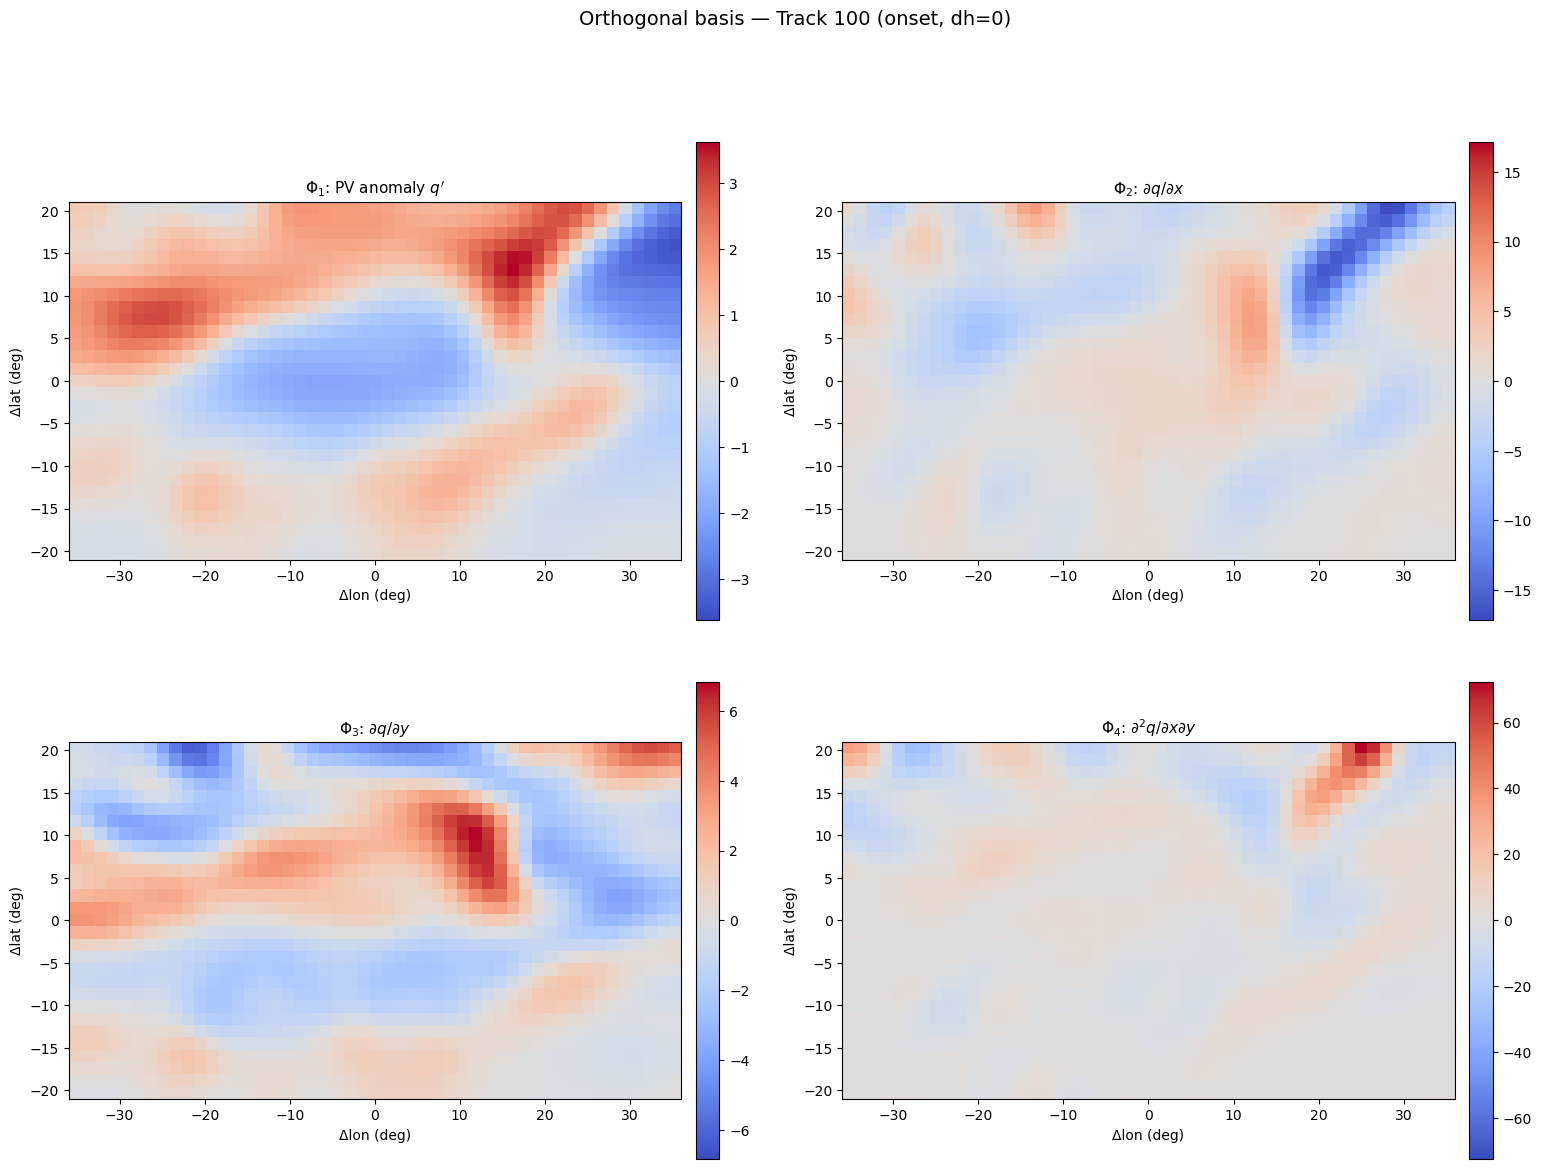

In [4]:
fig = plot_four_basis(
    basis.phi_int, basis.phi_dx, basis.phi_dy, basis.phi_def,
    x_rel, y_rel,
    suptitle="Orthogonal basis — Track 100 (onset, dh=0)",
)
plt.show()

## 4  Project PV tendency onto basis

In [5]:
from pvtend.decomposition.smoothing import gaussian_smooth_nan

pv_dt = d0["pv_anom_dt"]   # dq'/dt (weighted-average)
pv_dt_smooth = gaussian_smooth_nan(pv_dt, smoothing_deg=6.0, grid_spacing=1.5)

proj = project_field(pv_dt_smooth, basis)

print(f"β  (intensification) = {proj['beta']:.3e}  s⁻¹")
print(f"αx (zonal propagation) = {proj['ax']:.3f}  m/s")
print(f"αy (merid. propagation) = {proj['ay']:.3f}  m/s")
print(f"γ  (deformation)       = {proj['gamma']:.3e}  s⁻¹")
print(f"RMSE / max|dq/dt|      = {proj['rmse'] / (np.nanmax(np.abs(pv_dt_smooth)) + 1e-30):.3f}")

β  (intensification) = -5.351e-06  s⁻¹
αx (zonal propagation) = 7.729  m/s
αy (merid. propagation) = 4.380  m/s
γ  (deformation)       = 4.543e+05  s⁻¹
RMSE / max|dq/dt|      = 0.062


## 5  2-D component maps

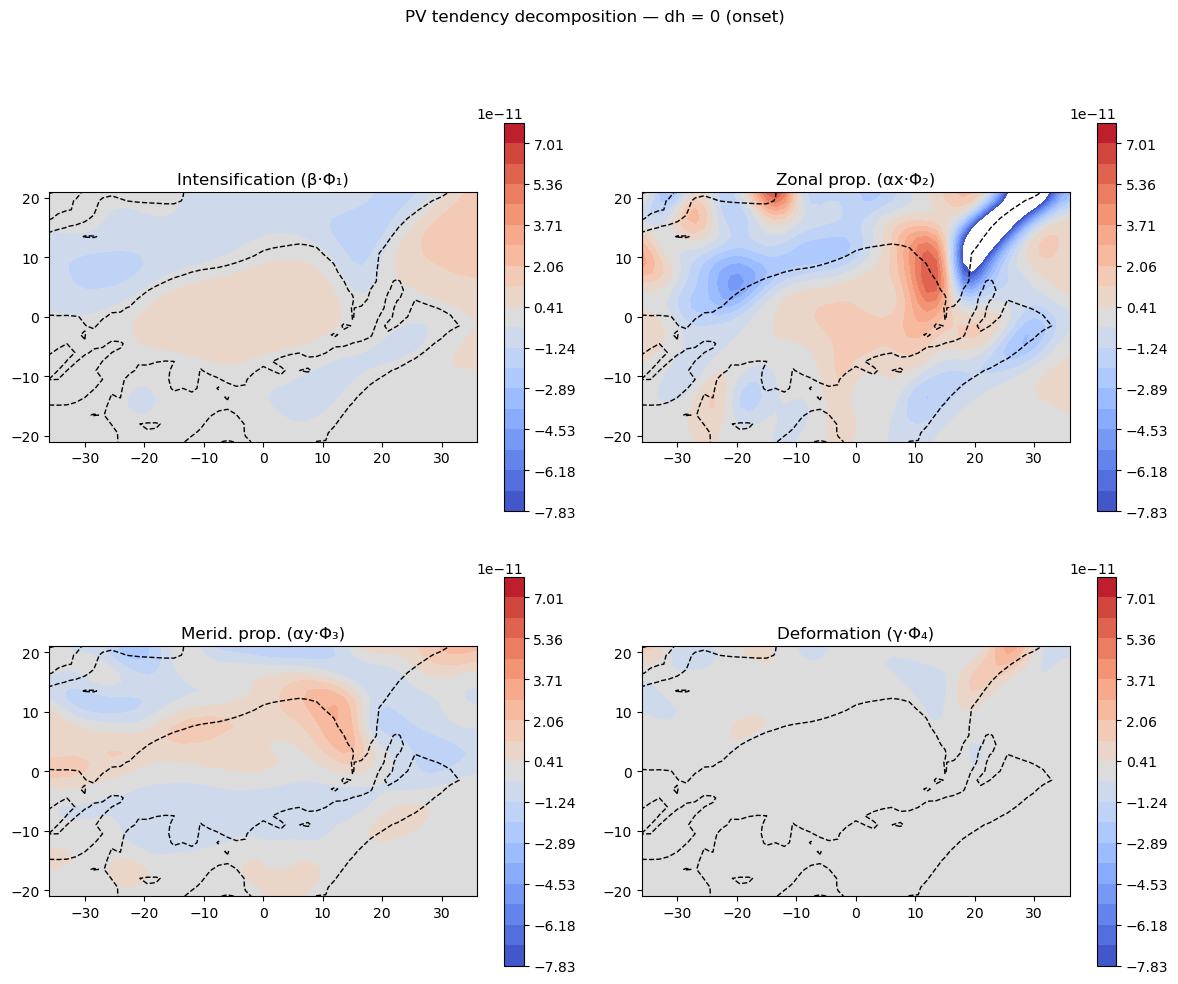

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
titles = ["Intensification (β·Φ₁)", "Zonal prop. (αx·Φ₂)",
          "Merid. prop. (αy·Φ₃)", "Deformation (γ·Φ₄)"]
fields = [proj["int"], proj["prop"][:, :] * 0,  # prop not separate by x/y in output
          proj["def"], proj["resid"]]

# Reconstruct individual components manually
beta_comp = proj["beta_raw"] * basis.phi_int
ax_comp   = proj["ax_raw"]   * basis.phi_dx
ay_comp   = proj["ay_raw"]   * basis.phi_dy
gamma_comp = proj["gamma_raw"] * basis.phi_def

components = [beta_comp, ax_comp, ay_comp, gamma_comp]
vmax = np.nanpercentile(np.abs(pv_dt_smooth), 95)

for ax, comp, title in zip(axes.flat, components, titles):
    cf = ax.contourf(x_rel, y_rel, comp,
                     levels=np.linspace(-vmax, vmax, 20), cmap="coolwarm")
    ax.contour(x_rel, y_rel, d0["pv_anom"], levels=[0], colors="k",
               linewidths=1.0, linestyles="--")
    ax.set_title(title)
    ax.set_aspect("equal")
    plt.colorbar(cf, ax=ax, shrink=0.8)

fig.suptitle("PV tendency decomposition — dh = 0 (onset)", y=1.02)
fig.tight_layout()
plt.show()

## 6  Lifecycle time curves (dh = −13 … +12)

In [7]:
import os, glob

dh_values = list(range(-13, 13))
coefs = {k: [] for k in ["beta", "ax", "ay", "gamma"]}

for dh in dh_values:
    sign = "+" if dh >= 0 else ""
    pattern = f"{DATA_ROOT}/blocking_tmp/{STAGE}/dh={sign}{dh}/track_100_*_dh{sign}{dh}.npz"
    files = sorted(glob.glob(pattern))
    if not files:
        for k in coefs:
            coefs[k].append(np.nan)
        continue

    dd = dict(np.load(files[0]))

    # Build basis at dh-1 (or dh=0 for the first step)
    dh_basis = max(dh - 1, -13)
    sign_b = "+" if dh_basis >= 0 else ""
    pattern_b = f"{DATA_ROOT}/blocking_tmp/{STAGE}/dh={sign_b}{dh_basis}/track_100_*_dh{sign_b}{dh_basis}.npz"
    files_b = sorted(glob.glob(pattern_b))
    if not files_b:
        for k in coefs:
            coefs[k].append(np.nan)
        continue
    db = dict(np.load(files_b[0]))

    b = compute_orthogonal_basis(
        db["pv_anom"], db["pv_anom_dx"], db["pv_anom_dy"],
        x_rel, y_rel, mask_negative=True,
        apply_smoothing=True, smoothing_deg=6.0, grid_spacing=1.5,
    )
    pv_dt_s = gaussian_smooth_nan(dd["pv_anom_dt"], smoothing_deg=6.0, grid_spacing=1.5)
    p = project_field(pv_dt_s, b)
    for k in coefs:
        coefs[k].append(p[k])

# Convert to arrays
for k in coefs:
    coefs[k] = np.array(coefs[k])

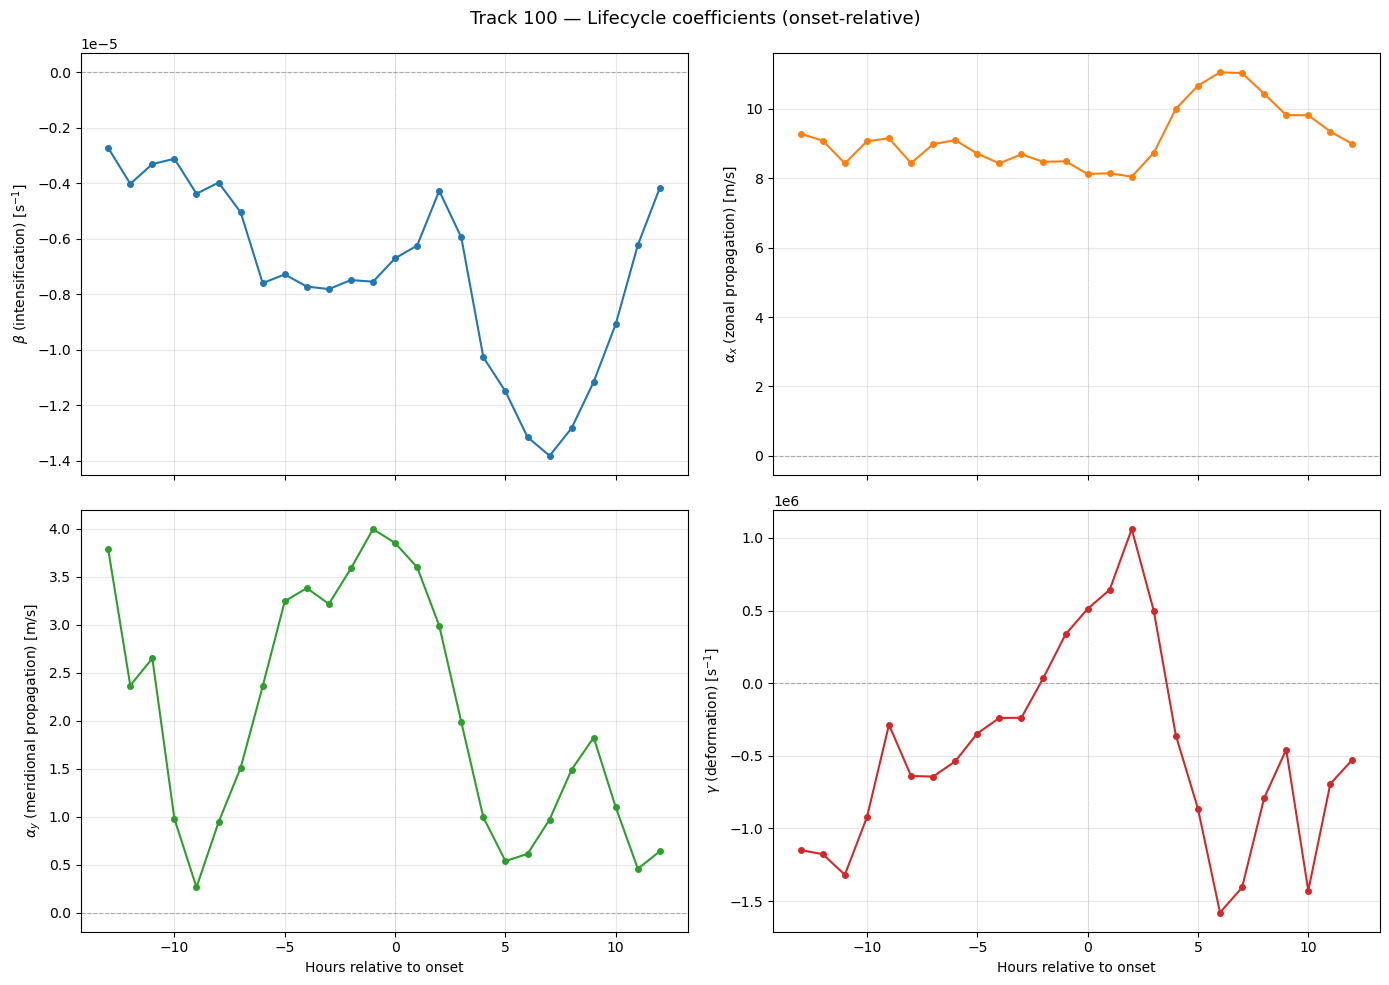

In [8]:
fig = plot_coefficient_curves(
    np.array(dh_values),
    coefs,
    title="Track 100 — Lifecycle coefficients (onset-relative)",
    xlabel="Hours relative to onset",
)
plt.show()

## Summary

- **`compute_orthogonal_basis`** builds the four Gram-Schmidt-orthogonalised
  basis fields (Φ₁…Φ₄) from the PV anomaly and its spatial gradients.
- **`project_field`** decomposes any 2-D field (e.g. dq'/dt) into
  intensification (β), propagation (αx, αy), and deformation (γ) coefficients.
- The lifecycle curve shows how these coefficients evolve
  from 13 h before onset to 12 h after.